In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [31]:
from keras.models import load_model

filepath = 'data/model.hdf5'
model = load_model(filepath)

In [23]:
import astropy.units as u
from fleck import generate_spots, Star
from batman import TransitParams
import sys
sys.path.insert(0, '../')
from sun import draw_random_sunspot_latitudes, draw_random_sunspot_radii

n_spots = 28 

inc_stellar = 90 * u.deg

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]
koi_stdevs = np.load('../data/oot_scatter.npy')

planet = TransitParams()
planet.per = 5
planet.a = 15
planet.rp = 0.058330305324663184
planet.w = 90
planet.ecc = 0
planet.t0 = 0
planet.limb_dark = 'quadratic'
planet.u = u_ld

times = np.linspace(planet.t0-0.1, planet.t0+0.1, 300)

star = Star(spot_contrast=spot_contrast, u_ld=u_ld, rotation_period=26)

n_iterations = 1

residual_ptp = []

b = 0.2#np.random.rand()
planet.inc = np.degrees(np.arccos(b/planet.a))

# Draw lambda randomly from actual lambda distribution of hot Jupiters
planet.lam = 0 #lambdas[np.random.randint(0, len(lambdas))]

# Draw spot latitude and radius from actual sunspot distributions

lcs = []
truth = []
for i in range(50): 
    if i % 2 == 0: 
        oddeven = [0]
    else: 
        oddeven = np.arange(n_spots)
    lons = 360 * np.random.rand(n_spots)[:, np.newaxis] * u.deg
    lats = draw_random_sunspot_latitudes(n_spots)[:, np.newaxis] 
    #radii = 0.02 + (0.08 - 0.02)*np.random.randn(n_spots)[:, np.newaxis] #0.04 * np.ones(n_spots)[:, np.newaxis]
    radii = 0.04 * np.ones(n_spots)[:, np.newaxis]

    lc, spots_occulted = star.light_curve(lons[oddeven], lats[oddeven], radii[oddeven], inc_stellar, planet=planet, 
                                          times=times, return_spots_occulted=True, fast=True)

    lc += koi_stdevs[np.random.randint(0, len(koi_stdevs))] * np.random.randn(len(lc))[:, np.newaxis]


    lcs.append(lc)
    truth.append(spots_occulted)

In [24]:
lcs = np.hstack(lcs)

In [25]:
lcs.shape

(300, 50)

True


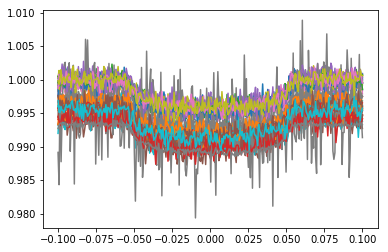

In [26]:
plt.plot(times, lcs)
print(spots_occulted)

[False  True False  True False  True False  True False  True False  True
  True  True False  True False  True False  True False  True False  True
 False  True False  True False  True False  True False  True False  True
 False  True False  True False  True False  True False  True False  True
 False  True]


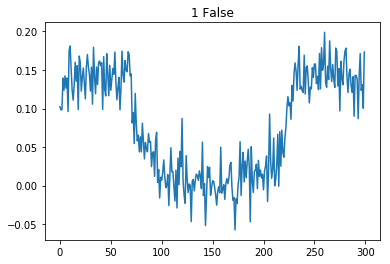

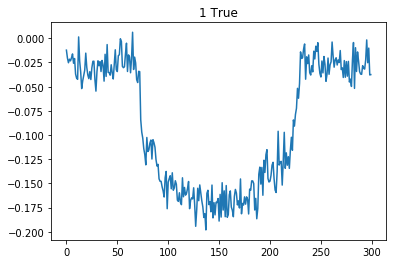

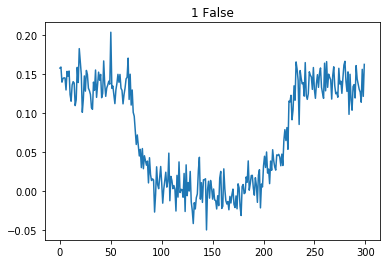

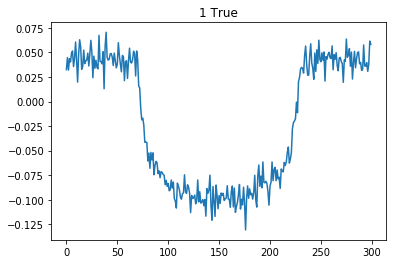

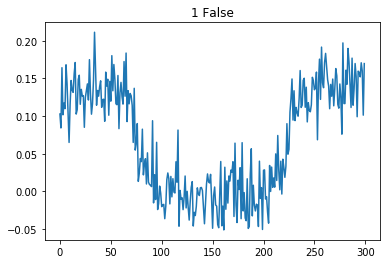

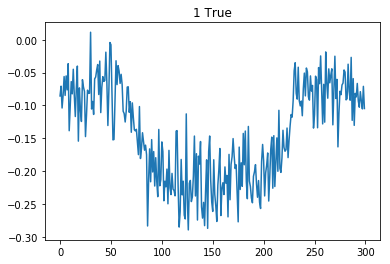

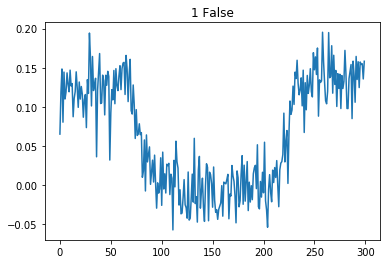

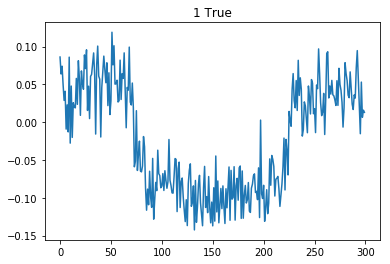

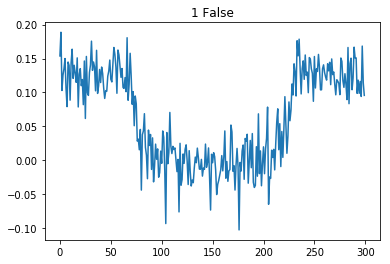

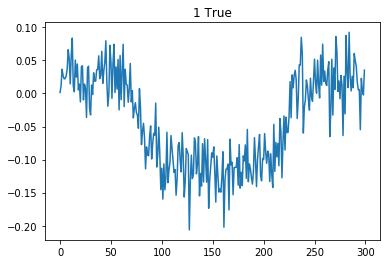

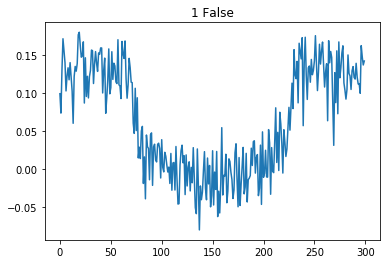

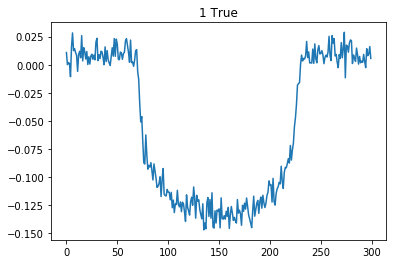

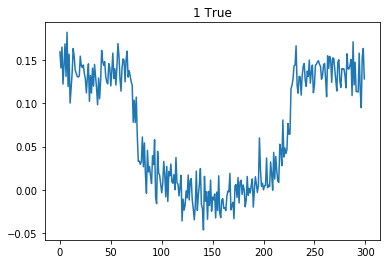

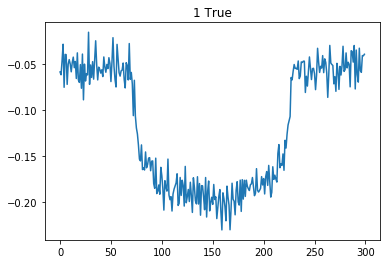

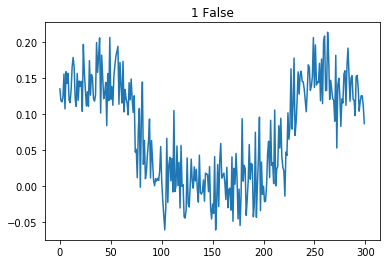

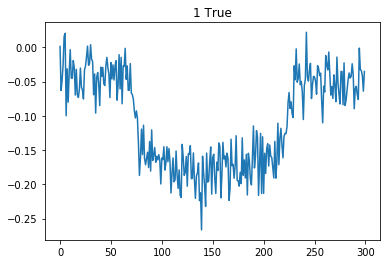

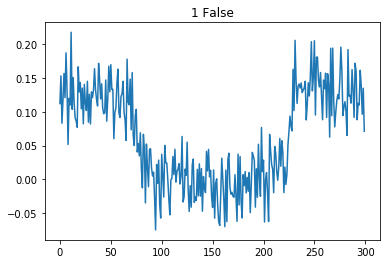

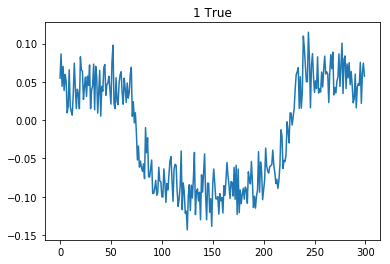

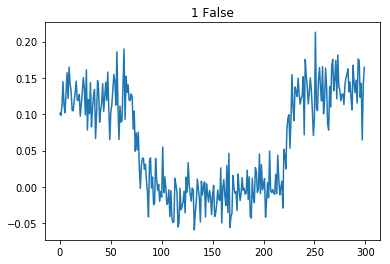

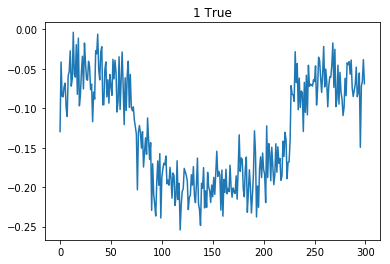

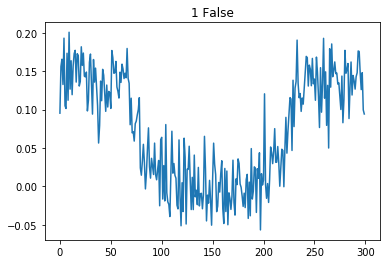

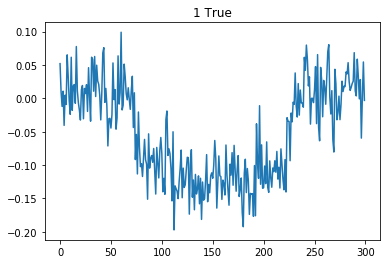

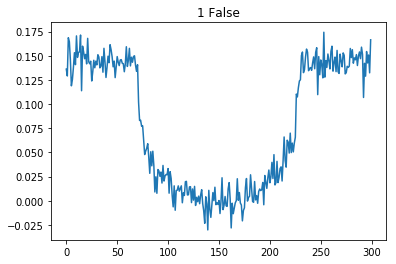

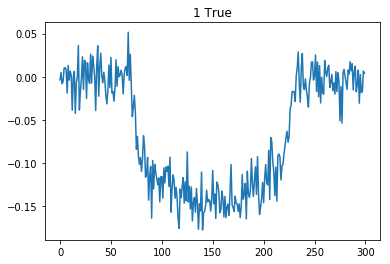

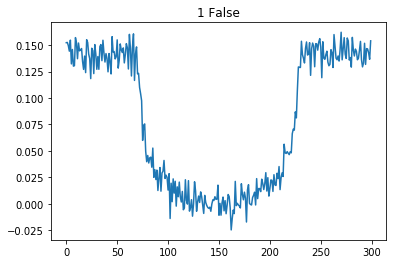

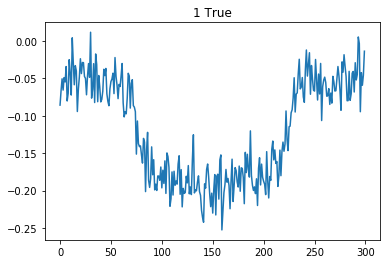

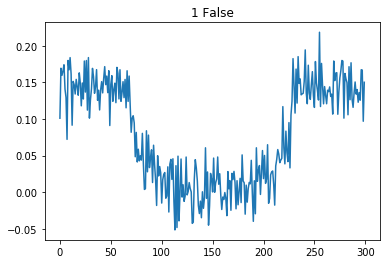

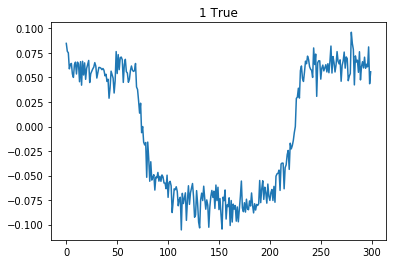

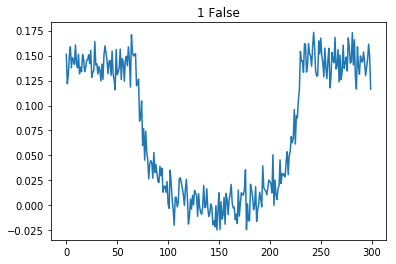

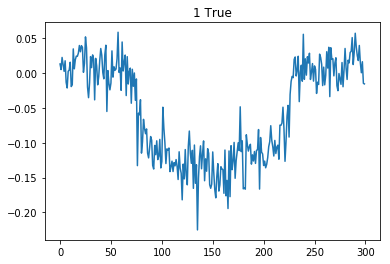

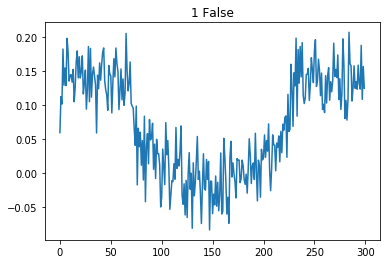

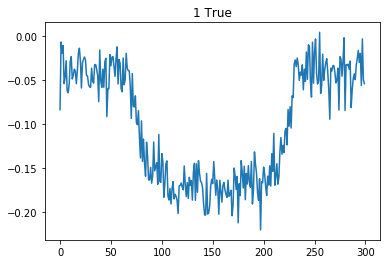

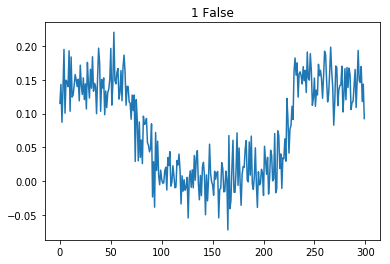

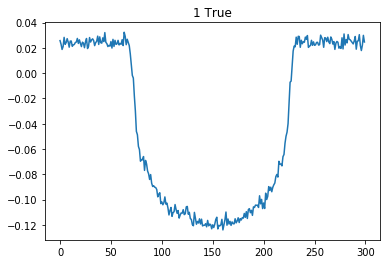

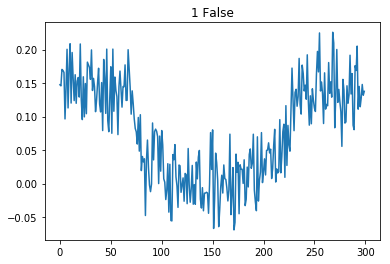

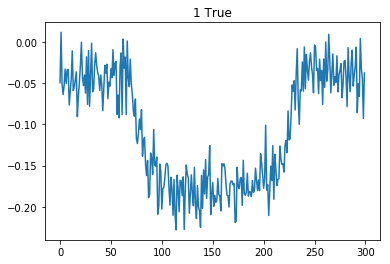

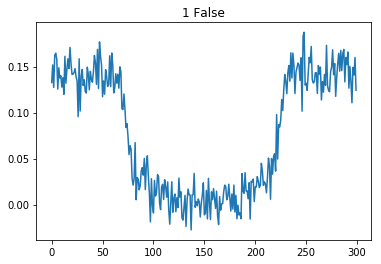

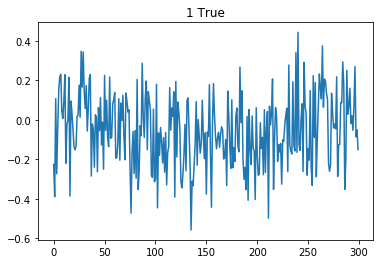

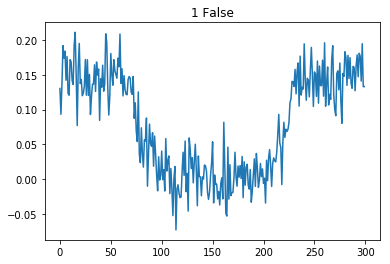

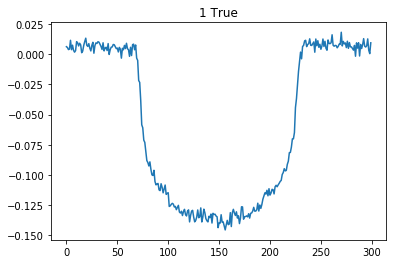

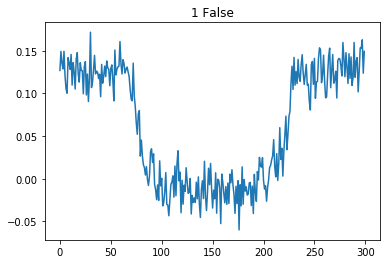

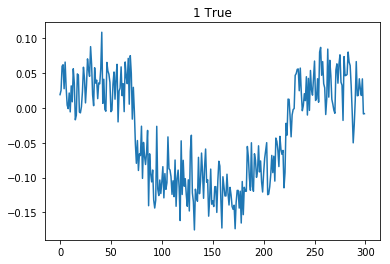

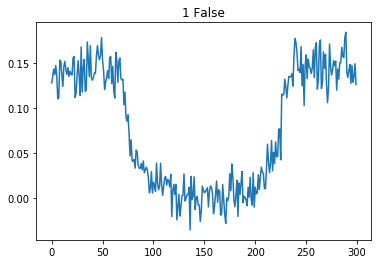

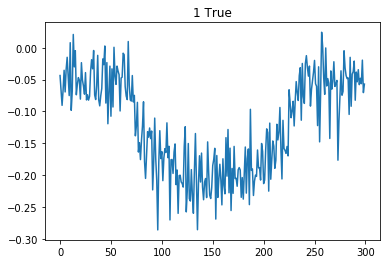

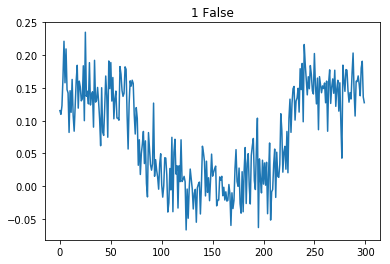

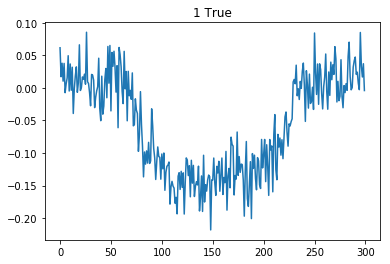

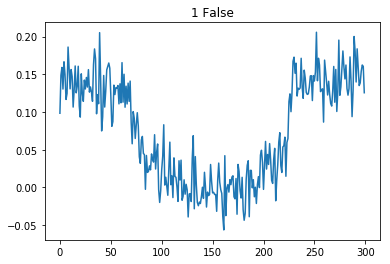

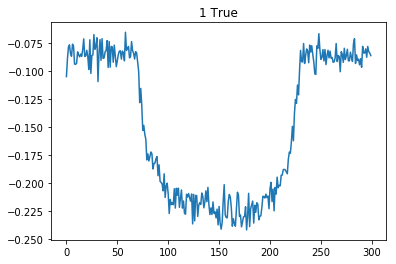

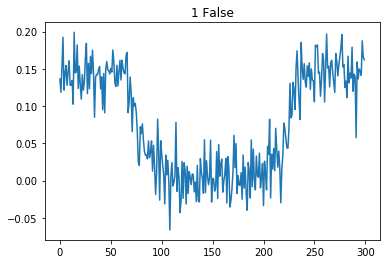

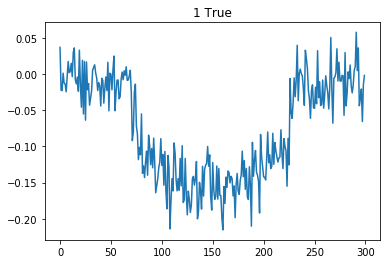

In [33]:
X = lcs.T[:, :, np.newaxis] 
X -= np.array(X).mean()
X /= X.ptp()

predict_y = model.predict(X)
print(np.argmax(predict_y, axis=1).astype(bool) == np.array(truth))

for i, x in enumerate(X): 
    plt.title(str(np.argmax(predict_y, axis=1)[i]) +' '+ 
              str(np.argmax(predict_y, axis=1)[i] == truth[i]))
    plt.plot(x)
    plt.show()

# X = np.random.randn(*X.shape)


